https://medium.com/analytics-vidhya/an-analysis-of-normalized-cuts-and-image-segmentation-1acb05d1a2e9 -> pojašnjen rad
https://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/Normalized%20Graph%20cuts.pdf -> prezentacija o radu
https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf -> rad

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [ ]:
class SpectralClustering:
    def __init__(self, sigma_I, sigma_X, r, lanczos_k, l, ncut_max):
        self.sigma_I = sigma_I #intsnsitiy scale
        self.sigma_X = sigma_X #spatial sclae
        self.r = r # spatial cutoff
        self.lanczos_k = lanczos_k
        self.l = l
        self.ncut_max = ncut_max  # threshold za splitting
        self.current_cluster_id = 0

    #-----------------------učitavanje slike-----------------------------
    def load_image(self, image_path):
        self.img = io.imread(image_path, as_gray=True).astype(np.float64)
        self.rows, self.cols = self.img.shape
        #------------------pretvaranje pixela u čvorove------------------
        self.X = np.array([(i, j) for i in range(self.rows) for j in range(self.cols)])
        self.intensities = self.img.flatten()
        self.n = self.X.shape[0]
        self.clusters = np.zeros(self.n, dtype=int) # ???
        return self
    
    """ 1.KORAK """
    #---------------------- iz rada formula za simm.----------------------
    def compute_similarity_matrix(self):
        W = np.zeros((self.n, self.n))  # simmilarity matrix prema brightness
        r_sq = self.r ** 2
        for i in range(self.n):
            for j in range(i + 1, self.n):
                spatial_dist_sq = np.sum((self.X[i] - self.X[j]) ** 2)
                if spatial_dist_sq < r_sq:
                    intensity_diff_sq = (self.intensities[i] - self.intensities[j]) ** 2
                    w_ij = np.exp(-intensity_diff_sq / (self.sigma_I ** 2)) * \
                           np.exp(-spatial_dist_sq / (self.sigma_X ** 2))
                    W[i, j] = w_ij
                    W[j, i] = w_ij
        
        self.W = W
        return self

    """ 2.KORAK """
    #---------------------- eigenvrijednosti - eigenvektori ----------------
    def compute_laplacian(self, W=None):
        #L = D - W -> nenormalizirana matrica
        if W is None:
            W = self.W
        D = np.diag(np.sum(W, axis=1))
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D))) # D^1/2
        return D_inv_sqrt @ (D - W) @ D_inv_sqrt

    # koristimo Lanczovou metodu da kretiramo manju matricu T umjesto L za 
    # izračunavanje eigen... built-in metodom .eigh
    # https://arxiv.org/pdf/2410.11090
    def lanczos(self, A, b):
        Q = np.zeros((len(b), self.lanczos_k))
        alphas = np.zeros(self.lanczos_k)
        betas = np.zeros(self.lanczos_k-1)
        
        q_prev = np.zeros(len(b)) # q_-1
        q_curr = b / np.sqrt(np.sum(b**2)) # q_0
        beta_prev = 0.0 # beta_-1
        
        #for 𝑛 = 0, 1, … , 𝑘 − 1 do...
        for i in range(self.lanczos_k):
            Q[:, i] = q_curr
            
            # korak 4: 𝐲𝑛+1 = 𝐀𝐪𝑛 − 𝛽𝑛−1𝐪𝑛−1
            # TODO: callable???
            if callable(A):
                y = A*q_curr - beta_prev * q_prev
            else:
                y = A @ q_curr - beta_prev * q_prev
            
            # korak 5: 𝛼𝑛 = 𝐪⊺𝑛*𝐲𝑛+1
            alpha_i = q_curr.T @ y
            alphas[i] = alpha_i
            
            # korak 6: 𝐳𝑛+1 = 𝐲𝑛+1 − 𝛼𝑛𝐪𝑛
            z = y - alpha_i * q_curr
            
            #korak 7: preskok
            
           
            if i < self.lanczos_k - 1:
                 # korak 8: 𝛽𝑛 = ‖𝐳𝑛+1‖2


                beta_i = np.sqrt(np.sum(z**2))
                betas[i] = beta_i
                
                # korak 9: 𝐪𝑛+1 = 𝐳𝑛+1/𝛽𝑛
                q_prev = q_curr
                q_curr = z / beta_i
                beta_prev = beta_i
        
        return Q, alphas, betas

    def compute_fiedler_vector(self, L):
        #b = np.random.rand(self.n)
        b = np.ones(L.shape[0]) # da maknemo randomness
        Q, alphas, betas = self.lanczos(L, b)
        # tridijagonalna matrica
        T = np.diag(alphas) + np.diag(betas, 1) + np.diag(betas, -1)
        # TODO: zamijeniti built-in .eigh funkciju
        eigvals, eigvecs = np.linalg.eigh(T)
        fiedler = Q @ eigvecs[:, 1]
        fiedler = np.sign(fiedler[np.argmax(np.abs(fiedler))]) * fiedler # consistent sign ??
        return fiedler

    """ 3.KORAK """
    #----------------------------- N-cut ----------------------------------
    # "Currently, the search is done by checking l evenly spaced possible 
    # splitting points, and computing the best Ncut among them.""
    #clusters = np.where(fiedler_vector >= 0, 1, 0)  # separacija prema predznaku
    def compute_ncut(self, W, D, A, B):
         # "Cut between A and B: sum of weights of edges between A and B"
        cut_AB = np.sum(W[A, :][:, B])
        assoc_A = np.sum(D[A])
        assoc_B = np.sum(D[B])
        return (cut_AB / assoc_A) + (cut_AB / assoc_B)

    
    
    def recursive_two_way(self, indices, parent_cluster_id=0):
        if len(indices) < self.l:
            self.clusters[indices] = parent_cluster_id
            return

        # podgrafovi za trenutni cluser
        W_sub = self.W[indices][:, indices]
        L_sub = self.compute_laplacian(W_sub)
        fiedler = self.compute_fiedler_vector(L_sub)
        
        #------------------------ Find optimal split ----------------------------
        sorted_idx = np.argsort(fiedler)
        min_ncut = np.inf
        best_split = self.l
        ncut_values = []
        
        for i in range(self.l, len(fiedler) - self.l, self.l):
            A = sorted_idx[:i]
            B = sorted_idx[i:]
            current_ncut = self.compute_ncut(W_sub, np.diag(np.sum(W_sub, axis=1)), A, B)
            if current_ncut < min_ncut:
                min_ncut = current_ncut
                best_split = i
                ncut_values.append(current_ncut) 
                
        "4. KORAK "
        #----------------------------- cut - stability ----------------------------
        # kako odrediti max cut:
            # empririjski [0.1,0.5] ->provjeriti
            # malo iznad prosjeka
        self.max_ncut = np.mean(ncut_values) # previše grupa
        
        # dijeliti ili ne
        if min_ncut < self.ncut_max:
            left = indices[sorted_idx[:best_split]]
            right = indices[sorted_idx[best_split:]]
            
            "5. KORAK"
            #----------------------------- two-way recursion ----------------------------
            self.current_cluster_id += 1
            new_cluster_id = self.current_cluster_id
            
            self.clusters[right] = new_cluster_id
            self.recursive_two_way(left, parent_cluster_id)
            self.recursive_two_way(right, new_cluster_id)
        else:
            self.clusters[indices] = parent_cluster_id
        

    # pipline koji poziva sve bitne funkcije
    def segment_image(self):
        self.compute_similarity_matrix()
        self.recursive_two_way(np.arange(self.n))
        return self.clusters.reshape((self.rows, self.cols))

    def visualize(self):
        segmented_img = self.clusters.reshape((self.rows, self.cols))
        
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(self.img, cmap='gray')
        axs[0].set_title('Original')
        axs[0].axis('off')
        
        axs[1].imshow(segmented_img, cmap='nipy_spectral')
        axs[1].set_title('Spectralno Grupiranje: Ncut + Lanczos')
        axs[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        

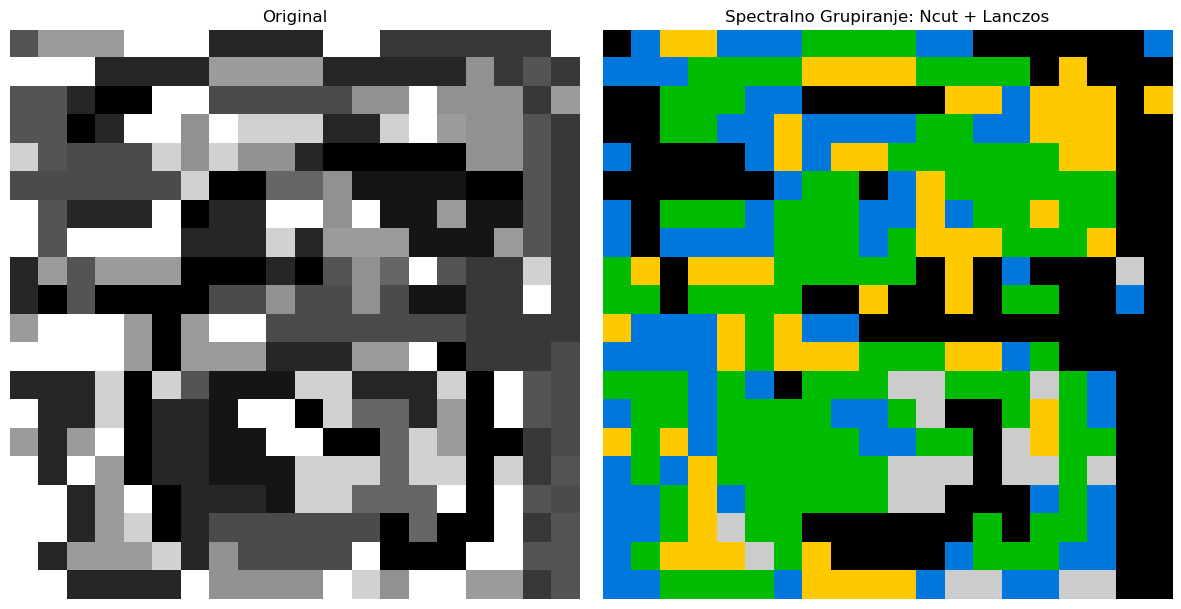

In [ ]:
clusterer = SpectralClustering(sigma_I=0.1, sigma_X=5.0, r=10, 
                                 lanczos_k=30, l=10, ncut_max=0.3)
clusterer.load_image('image3.png')
segmented = clusterer.segment_image()
clusterer.visualize()
  
  
#IDEJA:
    # za različine r - koliko susjeda uzimaju oko sebe
    # za različite k - koliko iteracija Lanczos ima - veći k, bolja aprox. T
    # za različite eigenvektore + graf linearni eigenvektor_index/ eigenvalue
    # za različite ncut_max -> kada stavim da je prosjek kod svakog dijeljenja, previše grupa
        
